## Explore training data

In [33]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [34]:
df = pd.read_csv('data/ohlcv.csv.gz', compression='gzip')
print(df.shape)
df.head(5)

(111655, 7)


,timestamp,symbol,open,high,low,close,volume
0,2023-01-01 00:00:00,BTC/USDT,16541.7700,16545.7000,16508.3900,16529.6700,4364.8357
1,2023-01-01 00:00:00,SOL/USDT,9.9700,10.0200,9.9300,9.9900,126479.6700
2,2023-01-01 00:00:00,ETH/USDT,1196.1300,1196.7000,1192.7200,1194.0900,5889.3840
3,2023-01-01 00:00:00,DOGE/USDT,0.0702,0.0703,0.0694,0.0698,40611931.0000
4,2023-01-01 00:00:00,XRP/USDT,0.3389,0.3390,0.3377,0.3385,11231966.0000


In [35]:
from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS
TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']

symbols = SYMBOLS #['BTC']
all_data = preprocess_data(df)
observations_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=symbols, 
    features=TECHNICAL_FEATURES
)

observations_df.shape, prices_df.shape

((22312, 40), (22312, 5))

In [36]:
# observation data
observations_df.head(5)

,BTC_price_change,BTC_volume_change,BTC_rsi,BTC_macd,BTC_macd_signal,BTC_macd_hist,BTC_bb_percent_b,BTC_bb_bandwidth,DOGE_price_change,DOGE_volume_change,...,ETH_bb_percent_b,ETH_bb_bandwidth,SOL_price_change,SOL_volume_change,SOL_rsi,SOL_macd,SOL_macd_signal,SOL_macd_hist,SOL_bb_percent_b,SOL_bb_bandwidth
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 19:00:00,0.0007,0.1359,54.6666,14.0088,7.8494,6.1595,1.0870,0.0055,0.0001,-0.3364,...,1.0691,0.0081,-0.0030,-0.3903,61.8820,-0.0039,-0.0222,0.0183,0.7189,0.0362
2023-01-01 20:00:00,0.0001,-0.1106,54.9600,16.0869,9.4969,6.5900,1.0047,0.0062,0.0014,0.0318,...,0.9550,0.0087,0.0000,-0.0746,61.8820,0.0010,-0.0176,0.0186,0.7244,0.0358
2023-01-01 21:00:00,0.0001,-0.1271,55.6444,17.7048,11.1385,6.5663,0.9516,0.0068,-0.0011,-0.6229,...,0.9967,0.0099,0.0010,-0.3287,61.8820,0.0057,-0.0129,0.0186,0.7748,0.0340
2023-01-01 22:00:00,-0.0003,0.0091,53.6614,18.4069,12.5921,5.8147,0.8644,0.0072,-0.0030,0.2171,...,0.8075,0.0102,-0.0010,-0.3512,60.4927,0.0085,-0.0086,0.0171,0.7634,0.0327
2023-01-01 23:00:00,0.0009,0.0424,58.3463,19.9142,14.0566,5.8576,0.9230,0.0077,0.0016,0.6759,...,0.7273,0.0101,0.0020,1.9274,61.4253,0.0122,-0.0045,0.0166,0.8174,0.0331


In [37]:
# prices data
prices_df.head(5)

symbol,BTC,DOGE,XRP,ETH,SOL
timestamp,,,,,
2023-01-01 19:00:00,16603.0800,0.0703,0.3390,1201.7800,9.9700
2023-01-01 20:00:00,16604.5100,0.0704,0.3387,1201.4000,9.9700
2023-01-01 21:00:00,16606.6800,0.0703,0.3386,1202.8500,9.9800
2023-01-01 22:00:00,16602.1200,0.0701,0.3386,1201.0300,9.9700
2023-01-01 23:00:00,16616.7500,0.0702,0.3387,1200.3400,9.9900


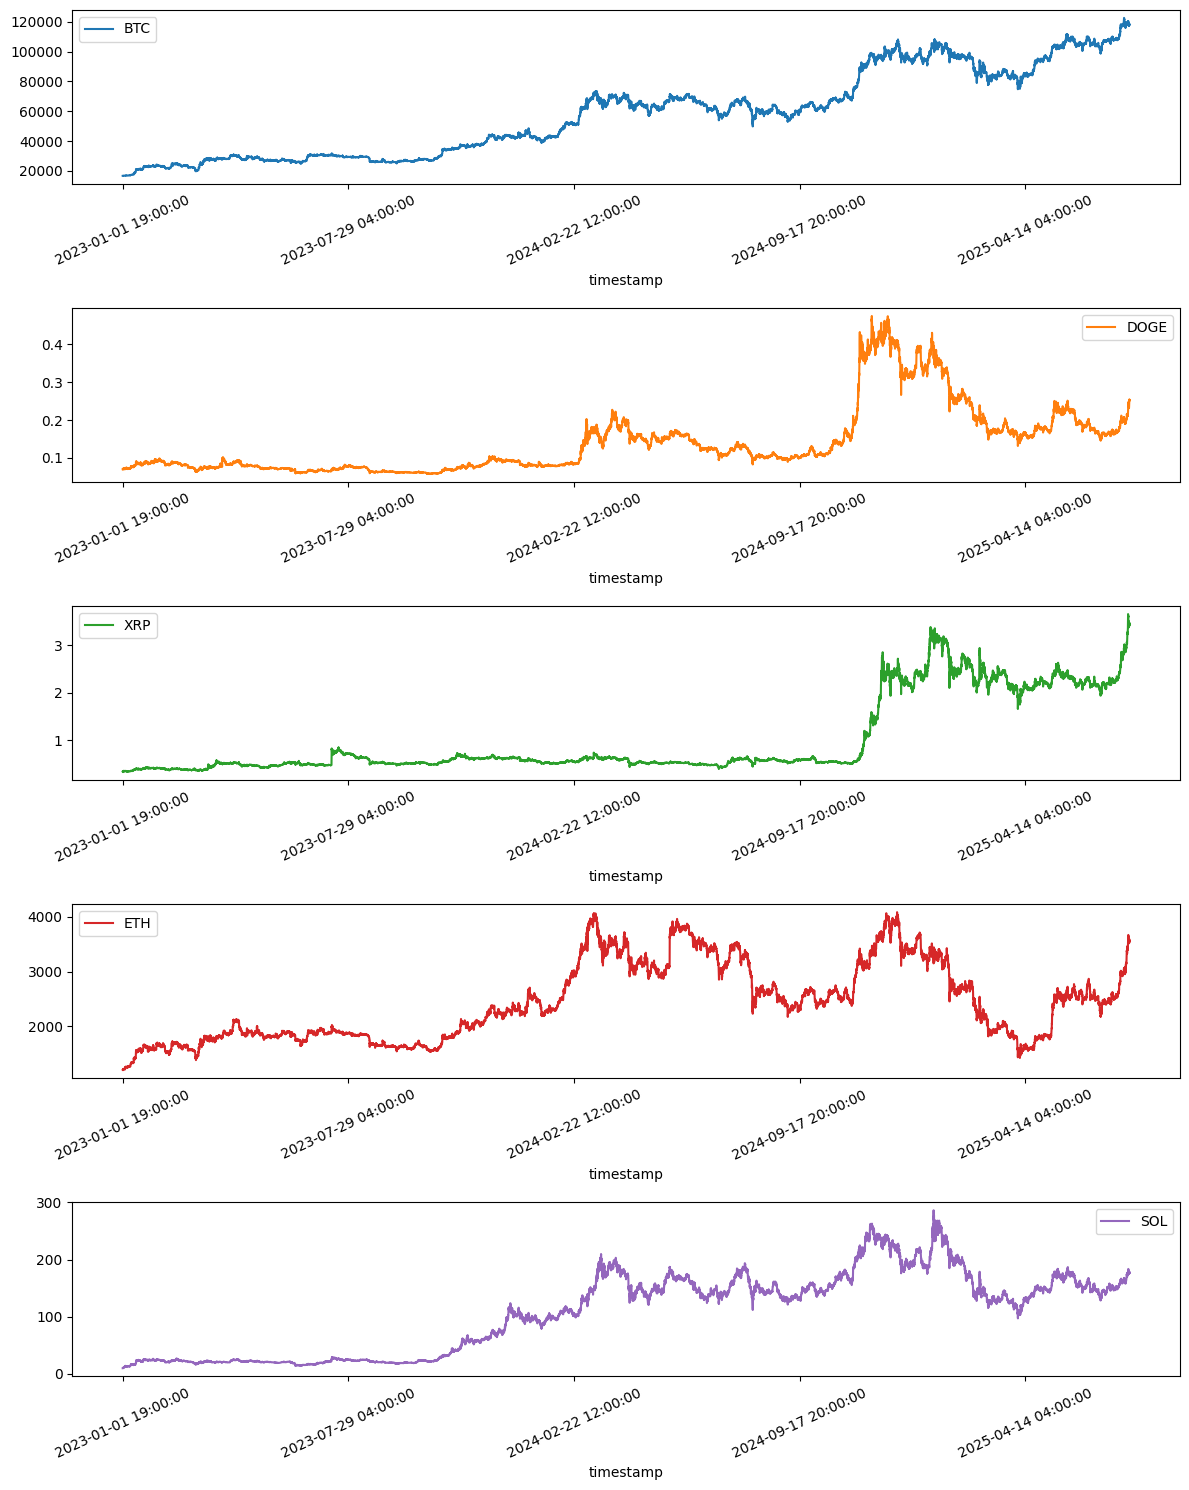

In [45]:
fig, a = plt.subplots(len(symbols), 1, figsize=(12, len(symbols) * 3), tight_layout=True)
prices_df.plot(ax=a, subplots=True, rot=25);

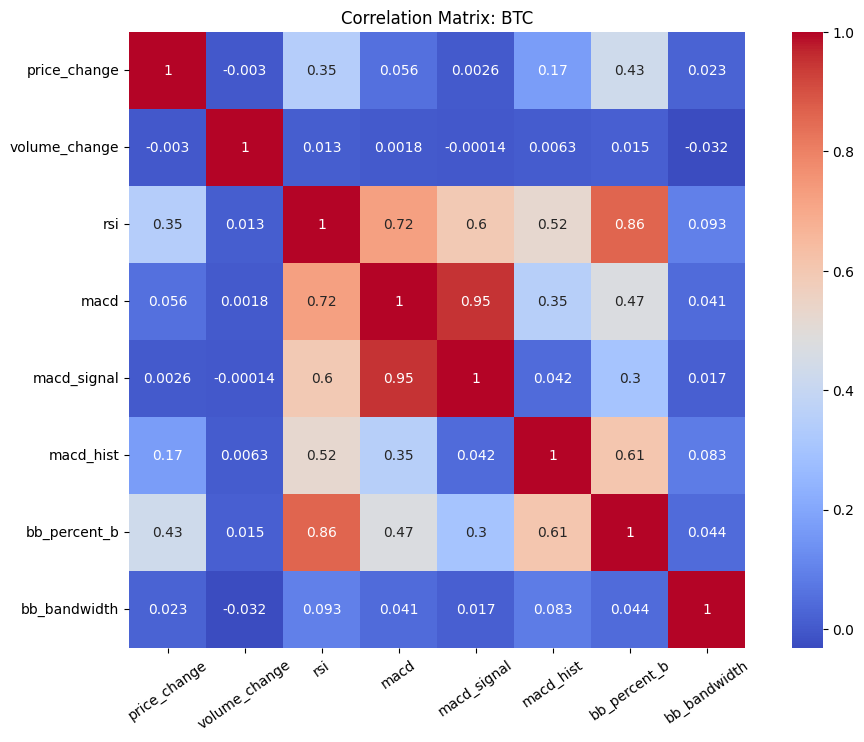

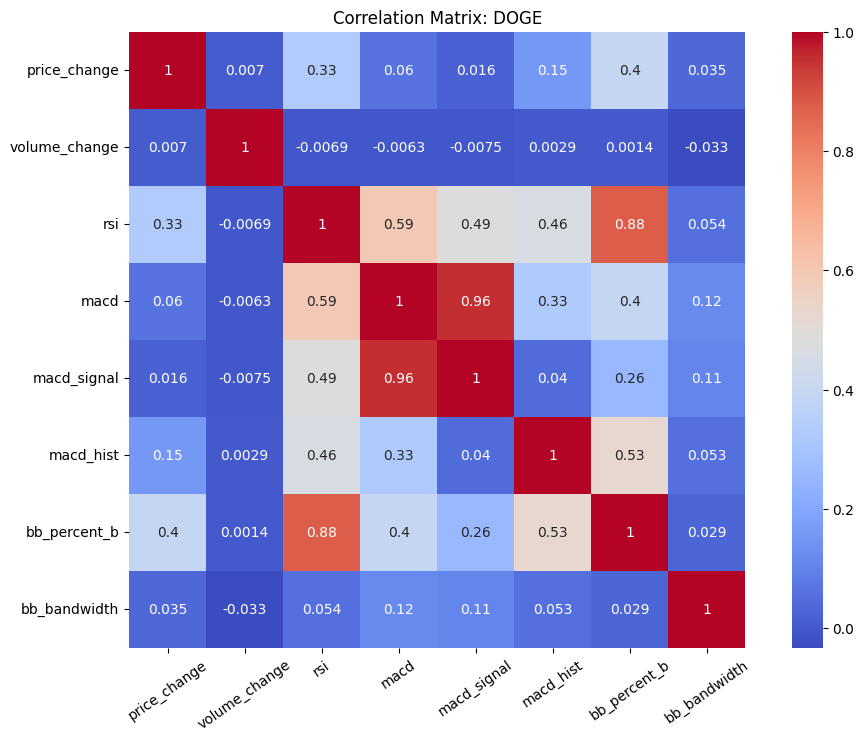

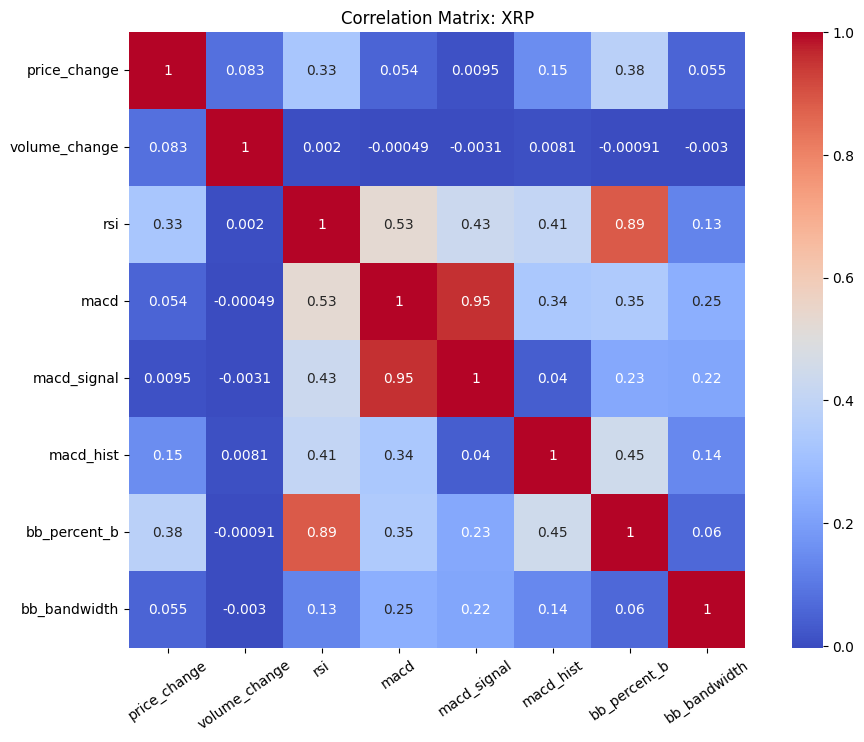

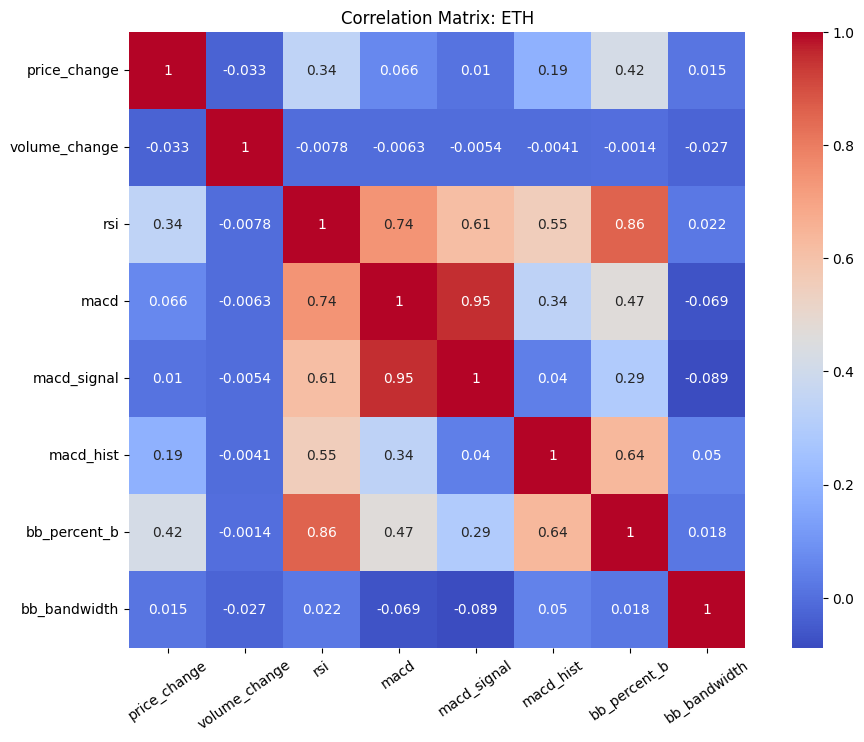

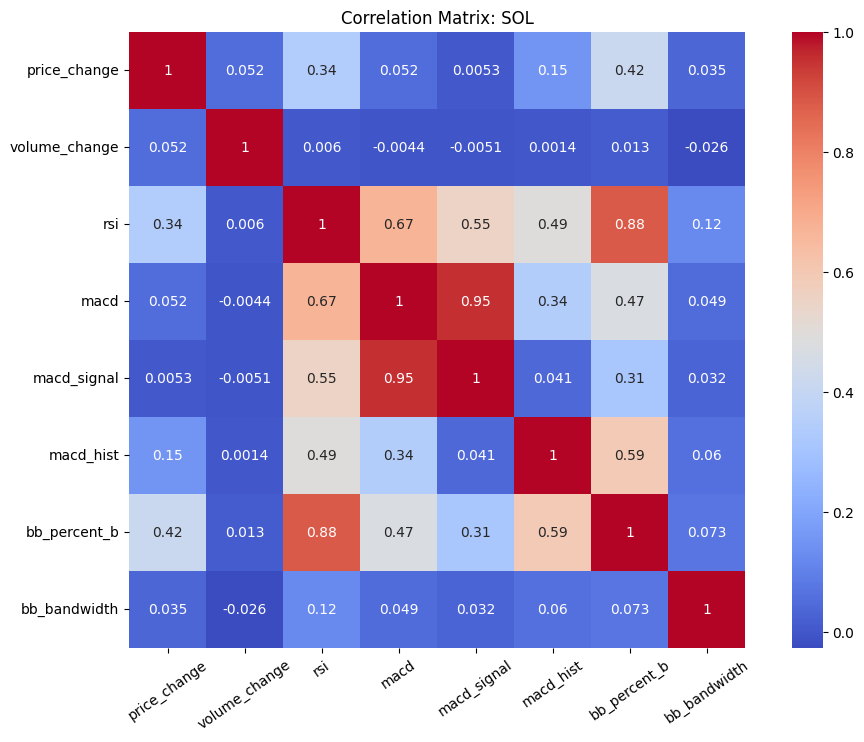

In [80]:
for symbol in SYMBOLS:
    columns = [f"{symbol}_{feature}" for feature in TECHNICAL_FEATURES]
    features_df = observations_df[columns].rename(columns=dict(zip(columns, TECHNICAL_FEATURES)))

    corr = features_df.corr()
    plt.figure(figsize=(12, 8))
    plt.title(f"Correlation Matrix: {symbol}")
    hm = sns.heatmap(corr, vmax=1, square=True, annot=True, cmap="coolwarm")
    hm.set_xticklabels(hm.get_xticklabels(), rotation = 35)
    plt.show()